## Color Quantization

The key factor for successful colour quantization is the appropriate selection of the colour palette that sufficiently summarizes the information of the initial image.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from skimage.io import imread
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import time
import cv2
from sklearn.cluster import KMeans
import timeit

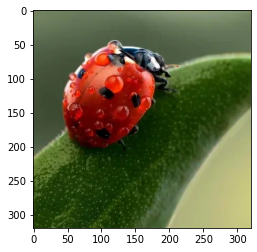

In [2]:
img = cv2.imread("insect.png")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(img)

## Uniform Quantization

In [3]:
def defineRegion(region , quantity):
#      """define regions we have 256 intenisties so 
#      if we choose to divide our image into 8 regions we get each region contains 256/8 = 32 which our quantity"""    
    region_list = []
    x = 0
    red_region = []
    green_region = []
    blue_region = []
    for i in range(region):
        region_list.append([x,x+quantity-1])
        red_region.append([])
        green_region.append([])
        blue_region.append([])
        x+= quantity
#     region_list list of lists that contains lower and upper limit of each region
    return region_list,red_region,green_region,blue_region
    

def regionIndex(colorValue ,region_list ):
    """returning index of region list which region that color belongs"""
    for idx , regionValue in enumerate(region_list):
        if colorValue >= regionValue[0] and colorValue <= regionValue[1]:
            return idx
    
def uniformQuantization(img,region = 8,quantity = 32):
    """apply uniform quantization on img"""
#     to calculate time taken
    start = timeit.default_timer()
#     define regions lists
    region_list,red_region,green_region,blue_region = defineRegion(region,quantity)
    
    for rows in img:
        for pixel in rows:
            red = pixel[0]
            green = pixel[1]
            blue = pixel[2]
        #get index of region where the color belonges to 
            red_region[int(regionIndex(red,region_list))].append(red)
            green_region[int(regionIndex(green,region_list))].append(green)
            blue_region[int(regionIndex(blue,region_list))].append(blue)
            
    red_color_per_region = [0 for i in range(region)]
    green_color_per_region = [0 for i in range(region)]
    blue_color_per_region = [0 for i in range(region)]
#     find avarage of all colors in the regions
    for idx in range(region):
        red_color_per_region[idx] = np.mean(red_region[idx]).astype(int)
        green_color_per_region[idx] = np.mean(green_region[idx]).astype(int)
        blue_color_per_region[idx] = np.mean(blue_region[idx]).astype(int)
    
    newImg = np.copy(img)
#     replace each element in img with the avarage of each region 
    for rowIdx , rows in enumerate(img):
        for columnIdx, pixel in enumerate(rows):
            red = pixel[0]
            green = pixel[1]
            blue = pixel[2]
            
            newImg[rowIdx,columnIdx][0] = red_color_per_region[regionIndex(red,region_list)]
            newImg[rowIdx,columnIdx][1] = green_color_per_region[regionIndex(green,region_list)] 
            newImg[rowIdx,columnIdx][2] = blue_color_per_region[regionIndex(blue,region_list)] 
    stop = timeit.default_timer()        
    return newImg , stop-start

Time Taken = 3.480798500124365


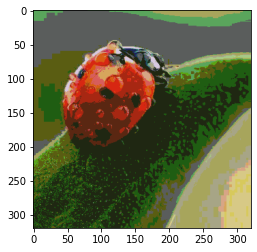

In [4]:
quantized,t = uniformQuantization(img,4,64)
print(f"Time Taken = {t}")
plt.imshow(quantized)

Time Taken = 5.419823499862105


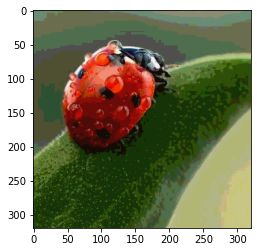

In [5]:
quantized,t = uniformQuantization(img,8,32)
print(f"Time Taken = {t}")
plt.imshow(quantized)

Simple Example :  If a color C is (3,34,189), it will go into region R(0-31), G(32-63) and B(160-191). Now if the average of all the Red colors falling in region R(0-31) is 16, Green G(32-63) is 48 and Blue B(160-191) is 178,
    then the color C = (3,34,189) will become C = (16, 48, 178) after quantization.

Uniform Quantization which was a simple way of reducing the colors in the image. Though it’s easy to implement, it doesn’t always yield good results when there are many colors belonging to the same region. Also, a lot of color regions will not have any colors mapped to them resulting in color map entries get wasted.



## Kmean

In [6]:
def colorQuantizationKmean(img,kCluster):

    #     Reshaping img to be features of kmean cluster
    h,w = img.shape[:2]
    imgReshaped = img.reshape((-1,3))
    imgReshaped = np.float32(imgReshaped)
    #     Time Taken 
    start = timeit.default_timer()
    
    #    create Kmean Cluster
    k_mean = KMeans(n_clusters=kCluster)
    labels = k_mean.fit_predict(imgReshaped)
    quantized = k_mean.cluster_centers_.astype("uint8")[labels]
    quantized = quantized.reshape((h,w,3))
    quantized = cv2.cvtColor(quantized, cv2.CV_8U)
    
    stop = timeit.default_timer()
    
    return quantized ,stop - start

#### Quantizing Image into 8 Color (clusters)

K-means is used to find 8 color clusters
Time Taken = 1.4465779999736696


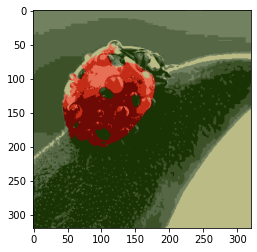

In [7]:
quantized ,t = colorQuantizationKmean(img,kCluster = 8)
print(f"K-means is used to find 8 color clusters")
print(f"Time Taken = {t}")
plt.imshow(quantized)

#### Quantizing Image into 16 Color (clusters)

K-means is used to find 16 color clusters
Time Taken = 3.5585491999518126


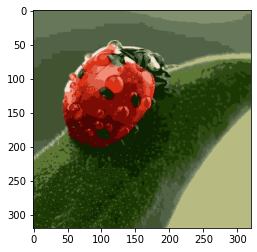

In [8]:
quantized , t = colorQuantizationKmean(img,kCluster = 16)
print(f"K-means is used to find 16 color clusters")
print(f"Time Taken = {t}")
plt.imshow(quantized)

#### Quantizing Image into 32 Color (clusters)

K-means is used to find 32 color clusters
Time Taken = 8.046841700095683


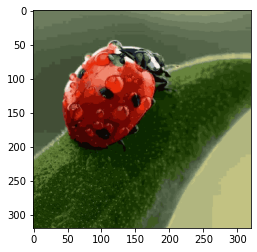

In [9]:
quantized,t = colorQuantizationKmean(img,kCluster = 32)
print(f"K-means is used to find 32 color clusters")
print(f"Time Taken = {t}")
plt.imshow(quantized)

algorithm initially chooses K centroids randomly from the given data and on each step assigns each data point to the closest centroid. When all data points (features) have been assigned to a centroid, each mean of the K clusters is recalculated and the two means are the new two centroids. The procedure is repeated until no update 

get better results but with more time we could use miniBatchKMeans but it may lead to unstablity due to small batches but it saves time 

resources :
    https://towardsdatascience.com/colour-image-quantization-using-k-means-636d93887061
    https://scikit-learn.org/stable/auto_examples/cluster/plot_color_quantization.html
    